## Image reconstruction

Impressive results. Want to reproduce
* http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/

What about the TV regulariser?

In [ ]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt

from src import mri
from src import utils

(1, 380, 300, 3)


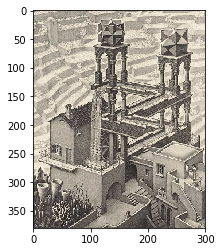

In [86]:
img = tf.image.decode_jpeg(tf.read_file('waterfall.jpg'))
img = tf.cast(img, tf.float32)/255
img = tf.expand_dims(img, 0)
# NOTE Works better with bigger images?
img = img[:, ::2, ::2, ...]
print(img.shape)
plt.imshow(img[0])

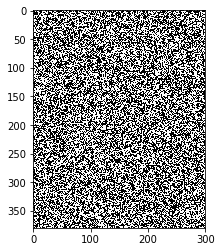

In [88]:
a = 0.5
m = np.random.choice([0, 1], (1, img.shape[1], img.shape[2], 1), p=[1-a, a])
mask = tf.constant(m, tf.float32)
plt.imshow(mask[0, :, :, 0], cmap='gray', interpolation='nearest')

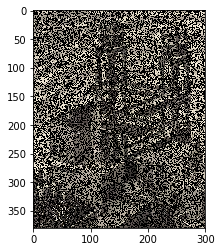

In [90]:
sampled_img = mask*img
plt.imshow(sampled_img[0])

In [208]:
class Sampler():
    def __init__(self, n):
        self.n = int(n)
        self.idx = None
    
    def __call__(self, x):
        # samples randomly from height, width, channels
        if self.idx is None:
            self.idx = tf.constant(np.random.randint(0, x.shape[1], self.n))
        return tf.layers.flatten(tf.gather(x, self.idx, axis=1))

sampler = Sampler(360*300*3*0.5)

In [209]:
x = tf.cast(img, tf.complex64)

def forward(x):
    # mask x or y!?
    # subsample in X
    # x = x*tf.complex(mask, mask)

    y = tf.fft2d(x)
    
    # subsample in Y
    y = tf.layers.flatten(y)
    y = sampler(y)
    
    y += utils.complex_random(tf.random_normal)(y.shape)

    return y

t = forward(x)

In [210]:
def dLdx(f, var, target, beta=0.5):
    with tf.GradientTape() as tape:
        x = tf.cast(var, tf.complex64)
        y = f(x)
        
        recon = tf.losses.mean_squared_error(y, target)  # x, tf.ifft2d(y)
        reg = beta*tf.reduce_mean(tf.abs(y))  # the l1 regularisation term
        loss = recon + reg 
        
        print('\rloss: {:.4f} recon: {:.4f} reg: {:.4f} '.format(loss, recon, reg), 
              end='', flush=True)

    return tape.gradient(loss, [var])

In [211]:
steps = 100
opt = tf.train.AdamOptimizer(0.1)

init = tf.random_normal(shape=x.shape)
# init = tf.ifft2d(t)

var = tf.contrib.eager.Variable(tf.real(init))

This is quite slow...
How does this algol scale with; size of image, many images, ...?


This is convex optimisation right!? Anything smarter we can do here?

loss: 5.7677 recon: 1.7691 reg: 3.9986 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 5.4749 recon: 1.7742 reg: 3.7007 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 5.2210 recon: 1.7802 reg: 3.4408 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 5.0214 recon: 1.8089 reg: 3.2125 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 4.8274 recon: 1.8148 reg: 3.0127 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 4.6642 recon: 1.8228 reg: 2.8413 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 4.5292 recon: 1.8408 reg: 2.6884 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 4.3963 recon: 1.8432 reg: 2.5530 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 4.3014 recon: 1.8663 reg: 2.4351 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 4.2066 recon: 1.8741 reg: 2.3325 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 4.1104 recon: 1.8601 reg: 2.2503 

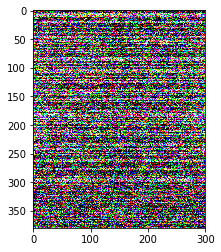

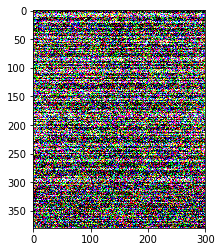

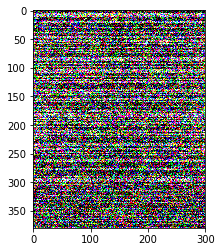

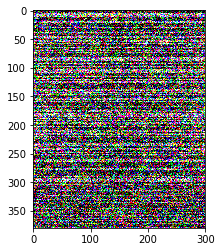

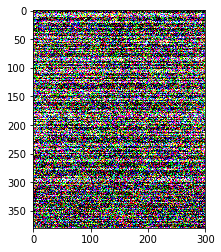

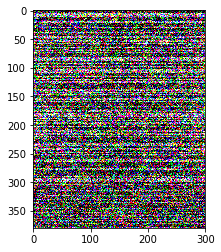

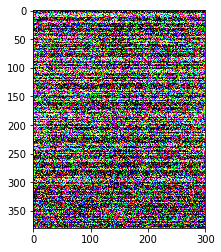

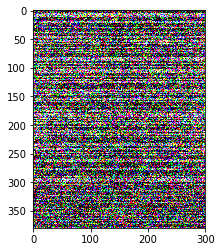

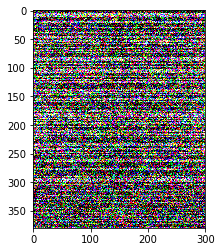

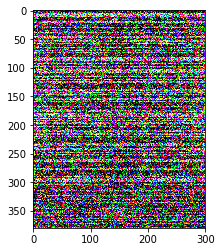

In [213]:
for i in range(steps):
    grads = dLdx(forward, var, target=t)
    gnvs = zip(grads, [var])
    opt.apply_gradients(gnvs, global_step=tf.train.get_or_create_global_step())
    
    if i % int(steps/10) == 0:
        plt.figure()
        plt.imshow(var[0])